In [ ]:
import deeplake
import jsonlines
import tqdm
import numpy as np
import json
import glob
import traceback
import os
import time

# input data format

```
one_segment_output = {
    "video_stem": str(Path(video_filepath).stem),
    "segment_id": str(Path(video_filepath).stem) + f"_{i}",
    "segment_index": np.int16(i),
    "total_segments": np.int16(len(whisper_segments)),
    "segment_total_time": whisper_segments[i]['end'] - whisper_segments[i]['start'],
    "captions": whisper_segments[i]['caption'],
    "segment_start_time": whisper_segments[i]['start'],
    "segment_end_time": whisper_segments[i]['end'],
    "num_frames_per_segment": np.int16(self.num_frames),
    "frame_embeddings": image_feature,
    "text_caption_embeddings": caption_feature,
    "segment_frames": segment_frame,
    "frame_embeddings_shape": image_feature.shape,          # trying the FLATTEN technique!
    "text_caption_embeddings_shape": caption_feature.shape,
    "segment_frames_shape": segment_frame.shape,
    # "scene_graph_captions": scene_graph_feature -- to be added in the subsequent step.
}
```

In [ ]:
# BASE_DIR            = '/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/'
BASE_DIR            = '/mnt/storage_ssd/'
BATCH_NAME          = 'parallel_15'
# BASE_DIR            = '/scratch/bbki/kastanday/whisper'
# MODEL_SAVE_PATH     = f'{BASE_DIR}/MODEL_CHECKPOINTS/{MODEL_VERSION_NAME}'
REMOTE_WHISPER_FILE = f'{BASE_DIR}/{BATCH_NAME}_whisper_output.jsonl'
REMOTE_CLIP_DIR     = f'{BASE_DIR}/{BATCH_NAME}_clip_output'
REMOTE_SCENE_FILE   = f'{BASE_DIR}/{BATCH_NAME}_scene_output.jsonl'

In [ ]:
@deeplake.compute
def file_to_deeplake(clip_path_and_scene_graph, sample_out):
    clip_npz_path, scene_seg = clip_path_and_scene_graph
    try:
        np_loaded = np.load(clip_npz_path, allow_pickle=True)
        scene_seg_list = json.loads(scene_seg)
    except Exception as e:
        print(f"Failed to load compressed numpy: {e}")
        return -1
    
    # iterate over segments
    for segment_index in range(np_loaded['arr_0'].item()['total_segments']):
        try:
            # frame_embedding       = np_loaded[f'arr_{segment_index}'].item()['frame_embeddings']
            # caption_embedding     = np_loaded[f'arr_{segment_index}'].item()['text_caption_embeddings']
            video_stem = np_loaded[f'arr_{segment_index}'].item()["video_stem"]
            segment_id = np_loaded[f'arr_{segment_index}'].item()["segment_id"]
            segment_index_val = np_loaded[f'arr_{segment_index}'].item()["segment_index"]
            total_segments = np_loaded[f'arr_{segment_index}'].item()["total_segments"]
            segment_total_time = np_loaded[f'arr_{segment_index}'].item()["segment_total_time"]
            captions = np_loaded[f'arr_{segment_index}'].item()["captions"]
            segment_start_time = np_loaded[f'arr_{segment_index}'].item()["segment_start_time"]
            segment_end_time = np_loaded[f'arr_{segment_index}'].item()["segment_end_time"]
            num_frames_per_segment = np_loaded[f'arr_{segment_index}'].item()["num_frames_per_segment"]
            frame_embeddings = np_loaded[f'arr_{segment_index}'].item()["frame_embeddings"]
            text_caption_embeddings = np_loaded[f'arr_{segment_index}'].item()["text_caption_embeddings"]
            segment_frames = np_loaded[f'arr_{segment_index}'].item()["segment_frames"]
            frame_embeddings_shape = np_loaded[f'arr_{segment_index}'].item()["frame_embeddings_shape"]
            text_caption_embeddings_shape = np_loaded[f'arr_{segment_index}'].item()["text_caption_embeddings_shape"]
            segment_frames_shape = np_loaded[f'arr_{segment_index}'].item()["segment_frames_shape"]
            
            local_segment_metadata = {
                'video_stem': video_stem,
                'segment_id': segment_id,
                'segment_index': int(segment_index_val),
                'total_segments': int(total_segments),
                'captions': captions,
                'segment_total_time': float(segment_total_time),
                'segment_start_time': float(segment_start_time),
                'segment_end_time': float(segment_end_time),
                'num_frames_per_segment': int(num_frames_per_segment),
                'segment_frames_shape': segment_frames_shape,
                'text_caption_embeddings_shape': text_caption_embeddings_shape,
                'frame_embeddings_shape': frame_embeddings_shape,
                'scene_graph_caption_txt': scene_seg_list[int(segment_index_val)]
                # 'segment_frames': ,
                # 'text_caption_embeddings': ,
                # 'frame_embeddings': ,
            }
            
            # add to dataset.
            assert 336 * 336 * 3 == segment_frames.size # warning image dimension is hard coded 
            sample_out.segment_frames.append(segment_frames.reshape(336, 336, 3)) # warning image dimension is hard coded
            sample_out.text_caption_embeddings.append(text_caption_embeddings)
            sample_out.frame_embeddings.append(frame_embeddings)
            sample_out.segment_metadata.append(local_segment_metadata)
        except Exception as e:
            # print(e)
            traceback.print_exc()
            continue
    
    return sample_out
        
    #     if sample_count >= 3:
    #         break
    # if sample_count >= 3:
    #     break


In [ ]:
# clip_npz_path_list = []
# scene_seg_list = []
clip_path_and_scene_graph = []

total_segments = 0
with jsonlines.open(REMOTE_SCENE_FILE, 'r') as scene_reader:
    # Zipping the scene graph with the clip + whisper embeddings
    # itr over videos
    for scene_graph_segments, clip_npz_path in tqdm.tqdm(zip(scene_reader, glob.glob(os.path.join(REMOTE_CLIP_DIR, '*'), recursive = True))):
        # scene_seg_list.append(scene_graph_segments)
        # clip_npz_path_list.append(clip_npz_path)
        clip_path_and_scene_graph.append( (clip_npz_path, scene_graph_segments) )
        total_segments += 1
print(total_segments)

In [ ]:
assert len(clip_path_and_scene_graph) == total_segments
len(clip_path_and_scene_graph)

In [ ]:
''' Create dataset '''

dataset_name = '/mnt/storage_ssd/v0testing'
ds = deeplake.empty(dataset_name, overwrite=True)

with ds:
    segment_frames          = ds.create_tensor('segment_frames', htype='image', dtype=np.uint8, sample_compression='jpg')
    video_stem              = ds.create_tensor('video_stem', htype='text', dtype=str, sample_compression=None)
    text_caption_embeddings = ds.create_tensor('text_caption_embeddings', htype='image', dtype=np.float16, sample_compression='lz4') # CLIP produces FP16 embeddings.
    frame_embeddings        = ds.create_tensor('frame_embeddings', htype='image', dtype=np.float16, sample_compression='lz4') # compression: https://docs.deeplake.ai/en/latest/Compressions.html
    segment_metadata        = ds.create_tensor('segment_metadata', htype='json', sample_compression='lz4') # compression: https://docs.deeplake.ai/en/latest/Compressions.html
    
    # clip_npz_path, sample_out, scene_seg
    # file_to_deeplake().eval(clip_path_and_scene_graph, ds, num_workers = 12)

In [ ]:
import time
sample_count = 0
start_time = time.monotonic()

with jsonlines.open(REMOTE_SCENE_FILE, 'r') as scene_reader:
    # Zipping the scene graph with the clip + whisper embeddings
    # itr over videos
    for scene_seg_list, clip_npz_path in tqdm.tqdm(zip(scene_reader, glob.glob(os.path.join(REMOTE_CLIP_DIR, '*'), recursive = True))):
        sample_count += 1
        if sample_count < 10_100:
            continue 
        try:
            np_loaded = np.load(clip_npz_path, allow_pickle=True)
            object_list_of_str = []
            scene_seg_list = json.loads(scene_seg_list)
        except Exception as e:
            print(f"Failed to load compressed numpy: {e}")
            continue
        
        # iterate over segments
        for segment_index in range(np_loaded['arr_0'].item()['total_segments']):
            try:
                # frame_embedding       = np_loaded[f'arr_{segment_index}'].item()['frame_embeddings']
                # caption_embedding     = np_loaded[f'arr_{segment_index}'].item()['text_caption_embeddings']
                video_stem = np_loaded[f'arr_{segment_index}'].item()["video_stem"]
                segment_id = np_loaded[f'arr_{segment_index}'].item()["segment_id"]
                segment_index_val = np_loaded[f'arr_{segment_index}'].item()["segment_index"]
                total_segments = np_loaded[f'arr_{segment_index}'].item()["total_segments"]
                segment_total_time = np_loaded[f'arr_{segment_index}'].item()["segment_total_time"]
                captions = np_loaded[f'arr_{segment_index}'].item()["captions"]
                segment_start_time = np_loaded[f'arr_{segment_index}'].item()["segment_start_time"]
                segment_end_time = np_loaded[f'arr_{segment_index}'].item()["segment_end_time"]
                num_frames_per_segment = np_loaded[f'arr_{segment_index}'].item()["num_frames_per_segment"]
                frame_embeddings = np_loaded[f'arr_{segment_index}'].item()["frame_embeddings"]
                text_caption_embeddings = np_loaded[f'arr_{segment_index}'].item()["text_caption_embeddings"]
                segment_frames = np_loaded[f'arr_{segment_index}'].item()["segment_frames"]
                frame_embeddings_shape = np_loaded[f'arr_{segment_index}'].item()["frame_embeddings_shape"]
                text_caption_embeddings_shape = np_loaded[f'arr_{segment_index}'].item()["text_caption_embeddings_shape"]
                segment_frames_shape = np_loaded[f'arr_{segment_index}'].item()["segment_frames_shape"]
                
                local_segment_metadata = {
                    'video_stem': video_stem,
                    'segment_id': segment_id,
                    'segment_index': int(segment_index_val),
                    'total_segments': int(total_segments),
                    'captions': captions,
                    'segment_total_time': float(segment_total_time),
                    'segment_start_time': float(segment_start_time),
                    'segment_end_time': float(segment_end_time),
                    'num_frames_per_segment': int(num_frames_per_segment),
                    'segment_frames_shape': segment_frames_shape,
                    'text_caption_embeddings_shape': text_caption_embeddings_shape,
                    'frame_embeddings_shape': frame_embeddings_shape,
                    'scene_graph_caption_txt': scene_seg_list[int(segment_index_val)]
                    # 'segment_frames': ,
                    # 'text_caption_embeddings': ,
                    # 'frame_embeddings': ,
                }
                
                # caption, caption_embed, clip_img_embed, scene_graph_caption, audio_embed (and segment_frame)
                
                # print(segment_frames.dtype)
                # print(text_caption_embeddings.dtype)
                # print(frame_embeddings.dtype)
                # print(segment_frames.dtype)
                
                with ds:
                    assert 336 * 336 * 3 == segment_frames.size # warning image dimension is hard coded 
                    ds.segment_frames.append(np.uint8(segment_frames.reshape(336, 336, 3))) # warning image dimension is hard coded
                    ds.text_caption_embeddings.append(np.float16(text_caption_embeddings))
                    ds.frame_embeddings.append(np.float16(frame_embeddings))
                    ds.video_stem.append(str(video_stem))
                    ds.segment_metadata.append(local_segment_metadata)
                sample_count += 1
                if sample_count % 50 == 0:
                    print("examples_added: ", sample_count)
                    print(f"⏰ Runtime for 50 samples: {(time.monotonic() - start_time):.2f} seconds")
                    start_time = time.monotonic()
            except Exception as e:
                print(f"Error while adding to dataset. Sample stem: {video_stem}")
                traceback.print_exc()
                continue
            # break
        # break
        #     if sample_count >= 3:
        #         break
        # if sample_count >= 3:
        #     break


In [10]:
# has error on file: 10120 of 19199

import deeplake
# dataset_name = '/mnt/storage_ssd/v0testing'
dataset_name = '/mnt/storage_ssd/FULL_v1_parallel_ingest_p15'
read_lake = deeplake.load(dataset_name)

read_lake.summary()

/mnt/storage_ssd/FULL_v1_parallel_ingest_p15 loaded successfully.
Dataset(path='/mnt/storage_ssd/FULL_v1_parallel_ingest_p15', tensors=['frame_embeddings', 'segment_frames', 'segment_metadata', 'text_caption_embeddings', 'video_stem'])

         tensor            htype          shape          dtype  compression
         -------          -------        -------        -------  ------- 
    frame_embeddings       image     (9735, 1, 768)     float16    lz4   
     segment_frames        image   (9735, 336, 336, 3)   uint8    jpeg   
    segment_metadata       json         (9735, 1)         str      lz4   
 text_caption_embeddings   image       (9735, 768)      float16    lz4   
       video_stem          text         (9735, 1)         str     None   


In [12]:
read_lake = deeplake.load(dataset_name)
hub_lake = deeplake.empty("hub://kastan/v0_parallel_15", overwrite=True)
deeplake.copy(read_lake, hub_lake)

/mnt/storage_ssd/FULL_v1_parallel_ingest_p15 loaded successfully.
Your Hub dataset has been successfully created!
The dataset is private so make sure you are logged in!
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/kastan/v0_parallel_15


Evaluating copy transform: 100%|██████████| 9735/9735 [00:30<00:00


Dataset(path='hub://kastan/v0_parallel_15', tensors=['frame_embeddings', 'segment_frames', 'segment_metadata', 'text_caption_embeddings', 'video_stem'])

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_0', 'segment_index': 0, 'total_segments': 490, 'captions': 'HELLO EVERYBODY AND WELCOME BACK TO MY SECOND CHANNEL I KNOW IT HAS BEEN A', 'segment_total_time': 3.49, 'segment_start_time': 0.320875, 'segment_end_time': 3.8108750000000002, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


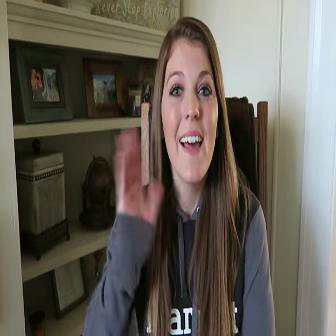

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_50', 'segment_index': 50, 'total_segments': 490, 'captions': 'ON SEPTEMBER NINETEENTH TWO THOUSAND AND TWELVE WITH ONE THOUSAND AND TWENTY-EIGHT PM AND I', 'segment_total_time': 5.358312500000011, 'segment_start_time': 234.44525, 'segment_end_time': 239.8035625, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


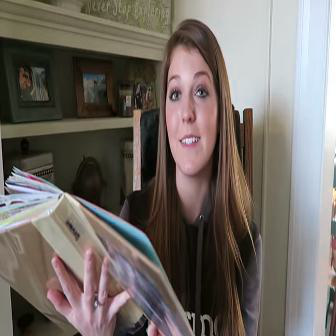

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_100', 'segment_index': 100, 'total_segments': 490, 'captions': 'WITH RYAN AND TOMMY WRESTLING ON THE FLOOR FELL ASLEEP ON THE COUCH YOU GAVE', 'segment_total_time': 5.768500000000017, 'segment_start_time': 459.9235, 'segment_end_time': 465.692, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


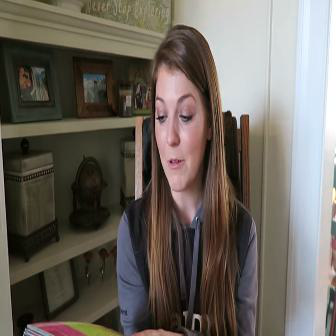

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_150', 'segment_index': 150, 'total_segments': 490, 'captions': "IN THERE I HAVE LIKE HAROLD'S FAVORITE MEMORIES LIKE MORE SMALL THINGS YOU KNOW SO", 'segment_total_time': 4.601999999999975, 'segment_start_time': 690.4983125, 'segment_end_time': 695.1003125, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


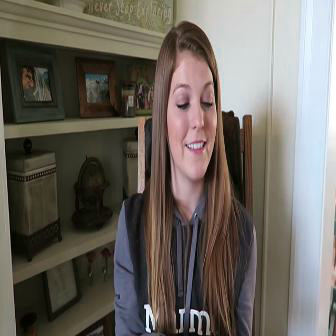

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_200', 'segment_index': 200, 'total_segments': 490, 'captions': 'CARDS FOR MY TWENTY-TWOND BIRTHDAY HE MADE ME THIS REALLY SWEET CARD AND GAVE IT', 'segment_total_time': 3.4500000000000455, 'segment_start_time': 924.8031875, 'segment_end_time': 928.2531875000001, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


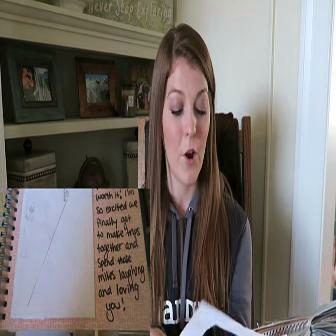

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_250', 'segment_index': 250, 'total_segments': 490, 'captions': "MY NEW HOME AND SOON WE'LL BE COMING OUT WITH A HOUSE TOUR BUT ANYWAYS", 'segment_total_time': 5.336562500000003, 'segment_start_time': 20.76975, 'segment_end_time': 26.1063125, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


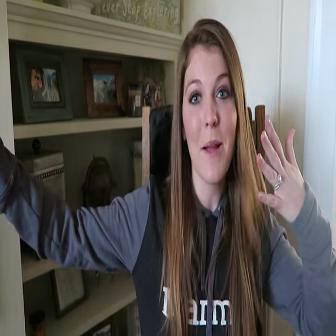

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_300', 'segment_index': 300, 'total_segments': 490, 'captions': "THE AISLE SO IT'S A PLAY ON WORDS TO THE FIRST LIKE MESSAGE THAT HE", 'segment_total_time': 3.772750000000002, 'segment_start_time': 255.358625, 'segment_end_time': 259.131375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


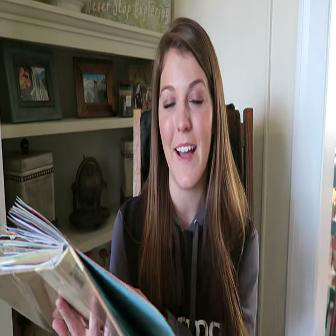

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_350', 'segment_index': 350, 'total_segments': 490, 'captions': "THINGS AND AT THIS TIME I DIDN'T VLOG SO READING BACK ON THOSE THINGS I", 'segment_total_time': 5.115062500000022, 'segment_start_time': 486.8680625, 'segment_end_time': 491.98312500000003, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


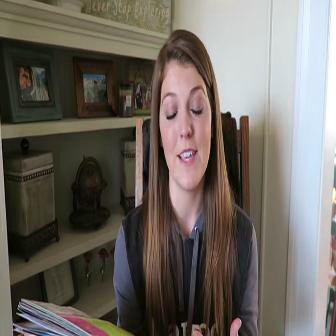

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_400', 'segment_index': 400, 'total_segments': 490, 'captions': "ANOTHER OTHER NOTES THAT HE'S NEVER SEEN UM LOTS OF DOODLES I HAVE IN HERE", 'segment_total_time': 6.072687499999915, 'segment_start_time': 712.5610625, 'segment_end_time': 718.63375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


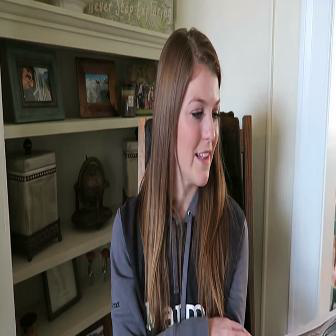

{'value': {'video_stem': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband', 'segment_id': 'JcKFFX3Jmgw_Rachel Earls_10373_Wedding Present For My Husband_450', 'segment_index': 450, 'total_segments': 490, 'captions': "FOURTEEN UM HEY SO WE'RE THE AMOUNT OF PLANE HEADED BACK TO WISCONSIN I CAN'T", 'segment_total_time': 5.296062500000062, 'segment_start_time': 947.0189375, 'segment_end_time': 952.315, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


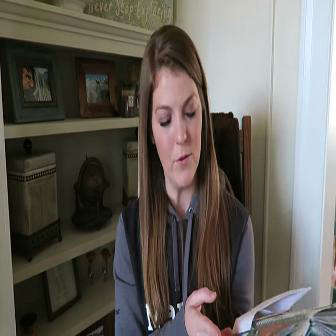

{'value': {'video_stem': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living', 'segment_id': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living_10', 'segment_index': 10, 'total_segments': 374, 'captions': "ME A LITTLE BIT ABOUT YOUR SISTER GOING ON COMING UP WITH THIS IDEA SHE'S", 'segment_total_time': 3.937250000000006, 'segment_start_time': 63.928375, 'segment_end_time': 67.86562500000001, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


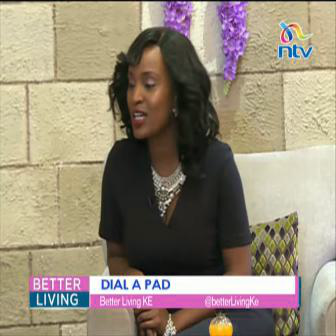

{'value': {'video_stem': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living', 'segment_id': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living_60', 'segment_index': 60, 'total_segments': 374, 'captions': "IN TERMS OF THE GAP ESPECIALLY IN KENYA KENYAN'S FORECAST MAINLY ON DONATIONS I KNOW", 'segment_total_time': 7.0354375000000005, 'segment_start_time': 334.2314375, 'segment_end_time': 341.266875, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


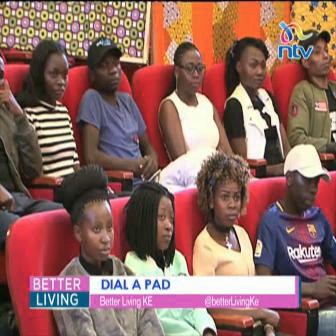

{'value': {'video_stem': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living', 'segment_id': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living_110', 'segment_index': 110, 'total_segments': 374, 'captions': "IDEA GIVE THEM A HAND EVERYBODY YEAH AND I'LL TALK TO SOME OF THE MEN", 'segment_total_time': 6.044875000000047, 'segment_start_time': 584.3336875, 'segment_end_time': 590.3785625, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


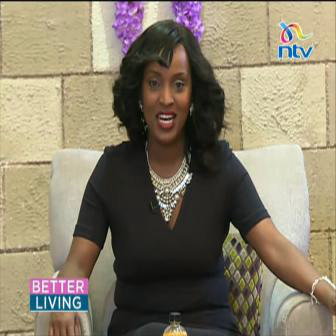

{'value': {'video_stem': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living', 'segment_id': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living_160', 'segment_index': 160, 'total_segments': 374, 'captions': 'AND I WILL SUPPORT YOU ON THIS SHOW AS MUCH AS YOU NEED IF YOU', 'segment_total_time': 4.1375000000000455, 'segment_start_time': 842.551625, 'segment_end_time': 846.689125, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


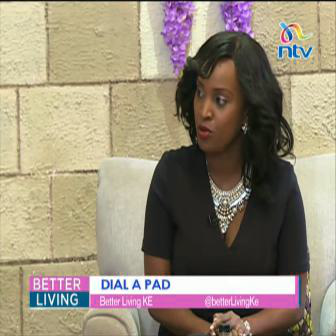

{'value': {'video_stem': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living', 'segment_id': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living_210', 'segment_index': 210, 'total_segments': 374, 'captions': 'MAJORITY OF KEYNES ARE ANDROID USERS SO YOU GUYS CAME UP WITH THE APP YEAH', 'segment_total_time': 5.200062500000001, 'segment_start_time': 140.132375, 'segment_end_time': 145.3324375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


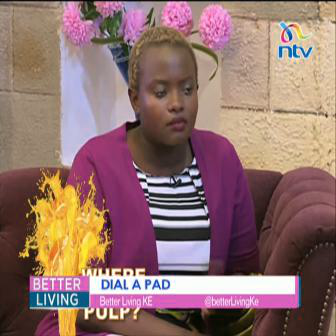

{'value': {'video_stem': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living', 'segment_id': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living_260', 'segment_index': 260, 'total_segments': 374, 'captions': "ARE ALSO GOING GREEN YOU'RE DOING IT RIGHT THE ENVIRONMENT YEAH AND SHOWING THAT WE'RE", 'segment_total_time': 5.020375000000001, 'segment_start_time': 400.159125, 'segment_end_time': 405.1795, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


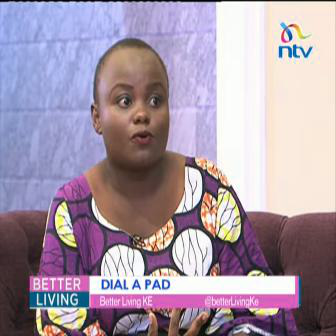

{'value': {'video_stem': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living', 'segment_id': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living_310', 'segment_index': 310, 'total_segments': 374, 'captions': 'TOLD US YOU GUYS YOU KNOW WHAT WILL BE GREAT IF WE HAD SOMETHING FOR', 'segment_total_time': 4.403999999999996, 'segment_start_time': 656.370875, 'segment_end_time': 660.774875, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


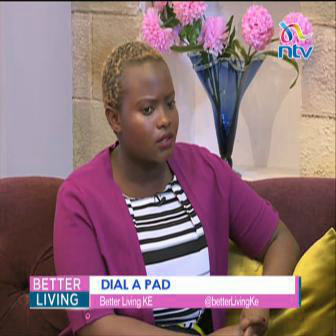

{'value': {'video_stem': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living', 'segment_id': 'JGhtpoho6pk_NTV Kenya_307_The quest of two sisters to avail sanitary pads to all women using technology - Better Living_360', 'segment_index': 360, 'total_segments': 374, 'captions': "THAN THAT YEAH APART FROM THE FACT THAT I KNEW A BIT THAT THERE'S A", 'segment_total_time': 6.247562499999958, 'segment_start_time': 898.87725, 'segment_end_time': 905.1248125, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


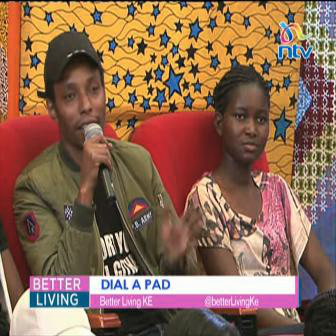

{'value': {'video_stem': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017', 'segment_id': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017_36', 'segment_index': 36, 'total_segments': 420, 'captions': 'OUR NEXT ONE BECAUSE THAT WAS SO AWESOME IT WAS JUST SO AWESOME AND I', 'segment_total_time': 3.8619375000000105, 'segment_start_time': 157.0389375, 'segment_end_time': 160.900875, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


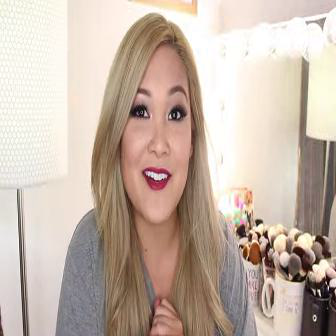

{'value': {'video_stem': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017', 'segment_id': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017_86', 'segment_index': 86, 'total_segments': 420, 'captions': "BUT THAT'S THE TECHNOLOGY THAT WENT INTO THESE PRODUCTS SO I'M A FAN YOU GUYS", 'segment_total_time': 4.860875000000021, 'segment_start_time': 378.3040625, 'segment_end_time': 383.1649375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


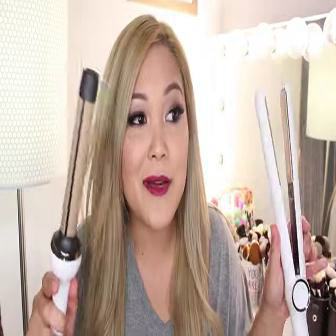

{'value': {'video_stem': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017', 'segment_id': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017_136', 'segment_index': 136, 'total_segments': 420, 'captions': "ON THE SKIN AND IF YOU HAVE DRY SKIN LIKE I DO IT'S JUST GOING", 'segment_total_time': 2.429812499999912, 'segment_start_time': 593.68825, 'segment_end_time': 596.1180625, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


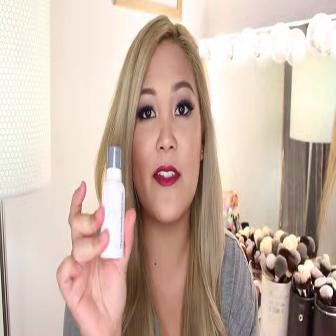

{'value': {'video_stem': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017', 'segment_id': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017_186', 'segment_index': 186, 'total_segments': 420, 'captions': 'IT AND I JUST FIND THAT POWDER IS JUST ALWAYS SO EASY TO WORK WITH', 'segment_total_time': 3.8246250000000828, 'segment_start_time': 833.3128125, 'segment_end_time': 837.1374375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


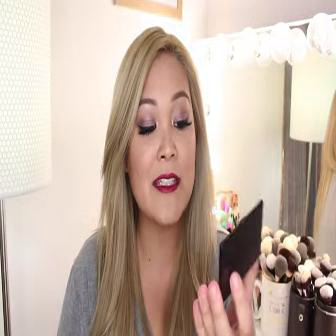

{'value': {'video_stem': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017', 'segment_id': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017_236', 'segment_index': 236, 'total_segments': 420, 'captions': "I JUST I LOOK AT THESE LIKE ALL THE TIME NOW I'M SO GLAD THAT", 'segment_total_time': 4.006000000000014, 'segment_start_time': 115.4089375, 'segment_end_time': 119.41493750000001, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


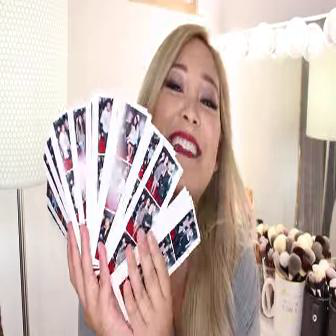

{'value': {'video_stem': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017', 'segment_id': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017_286', 'segment_index': 286, 'total_segments': 420, 'captions': 'I LIKE THESE THESE PRODUCTS WERE DESIGNED IN A WAY TO HAVE LESS HEAT LESS', 'segment_total_time': 6.123749999999973, 'segment_start_time': 328.7524375, 'segment_end_time': 334.87618749999996, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


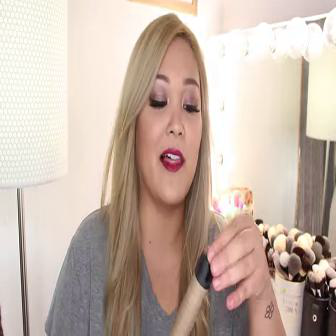

{'value': {'video_stem': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017', 'segment_id': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017_336', 'segment_index': 336, 'total_segments': 420, 'captions': 'INSTAGRAM LIVE STREAM YOU GUYS SEE THAT I YOU SEE LIKE THE PRODUCTS I USE', 'segment_total_time': 4.310812499999997, 'segment_start_time': 549.36825, 'segment_end_time': 553.6790625, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


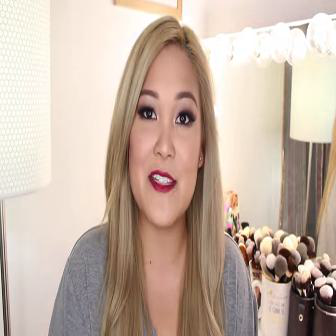

{'value': {'video_stem': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017', 'segment_id': 'Jw3q1JXzn-U_JaaackJack_6071_My June Favorites + June Recap 2017_386', 'segment_index': 386, 'total_segments': 420, 'captions': "IN A BOXY CHARM BOX BUT THIS IS THE BROW GAL BY TONYA CROOKS IT'S", 'segment_total_time': 6.101187500000037, 'segment_start_time': 786.8705625, 'segment_end_time': 792.97175, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


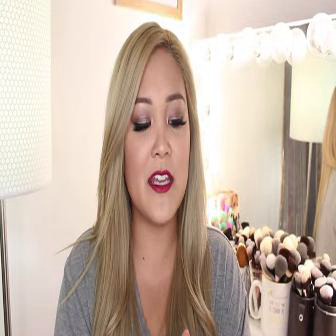

{'value': {'video_stem': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2', 'segment_id': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2_16', 'segment_index': 16, 'total_segments': 375, 'captions': 'AT THIS POINT IT DOES APPEAR THAT HE WILL BE SH SH SORRY THREE TWO', 'segment_total_time': 5.885562499999992, 'segment_start_time': 91.6975625, 'segment_end_time': 97.583125, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


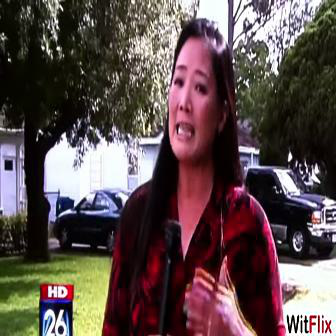

{'value': {'video_stem': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2', 'segment_id': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2_66', 'segment_index': 66, 'total_segments': 375, 'captions': 'OF EASTERN ENGLAND WITH CLOUDY SKIES BUT IN THE SUNSHINE IN NORTHWEST WALES AT RAF', 'segment_total_time': 4.530624999999986, 'segment_start_time': 380.270125, 'segment_end_time': 384.80075, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


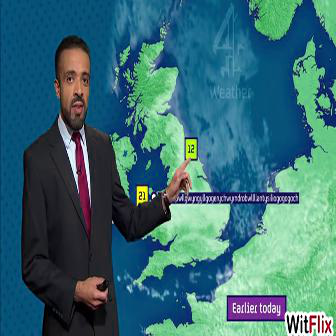

{'value': {'video_stem': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2', 'segment_id': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2_116', 'segment_index': 116, 'total_segments': 375, 'captions': "SLOW LET'S SEE HOW MUCH I'M BACK I CAN GO OVER THAT OH I GUESS", 'segment_total_time': 6.22331250000002, 'segment_start_time': 628.342, 'segment_end_time': 634.5653125, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


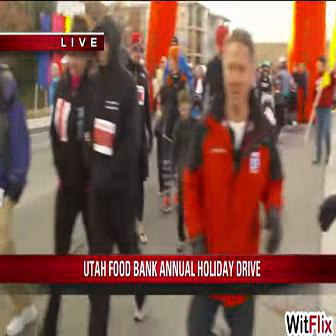

{'value': {'video_stem': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2', 'segment_id': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2_166', 'segment_index': 166, 'total_segments': 375, 'captions': 'MGM GRANDA MAKE SURE I COVER ALL THE HIGHLIGHTS AND OF COURSE COVER POST GAME', 'segment_total_time': 4.0355624999999975, 'segment_start_time': 225.552875, 'segment_end_time': 229.5884375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


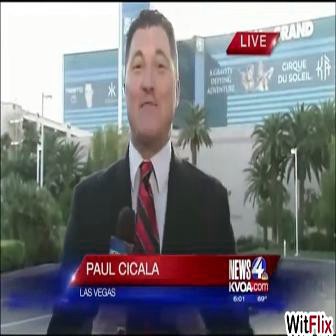

{'value': {'video_stem': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2', 'segment_id': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2_216', 'segment_index': 216, 'total_segments': 375, 'captions': 'THE LATUNA FIRE IN TWO THOUSAND AND SEVENTEEN SO BE CAREFUL WHEN YOU DRIVE THROUGH', 'segment_total_time': 5.5234375, 'segment_start_time': 491.84475, 'segment_end_time': 497.3681875, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


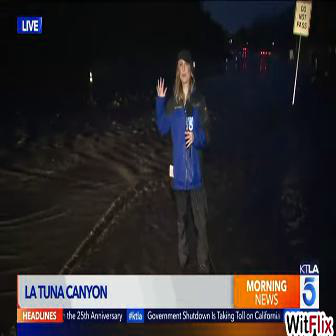

{'value': {'video_stem': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2', 'segment_id': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2_266', 'segment_index': 266, 'total_segments': 375, 'captions': 'TODAY HAS BEEN DESCRIBED AS SATURATED NOT WAY RAIN BUT BY HOUSES THOUSANDS HAVE BEEN', 'segment_total_time': 5.181624999999997, 'segment_start_time': 73.0078125, 'segment_end_time': 78.1894375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


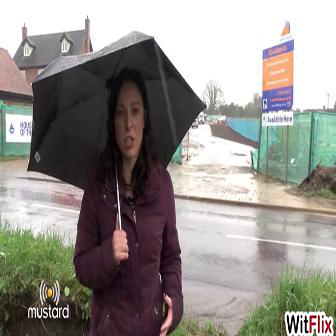

{'value': {'video_stem': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2', 'segment_id': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2_316', 'segment_index': 316, 'total_segments': 375, 'captions': 'GET OUT WHILE YOU STILL CAN I THINK STEEL BOILS AT ABOUT THIS TEMPERATURE SO', 'segment_total_time': 5.751687500000003, 'segment_start_time': 364.25625, 'segment_end_time': 370.0079375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


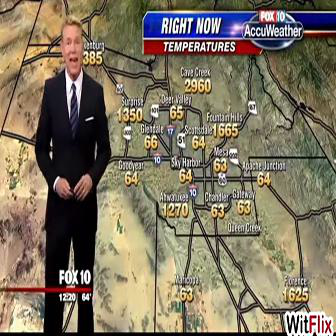

{'value': {'video_stem': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2', 'segment_id': 'JHIUIkZR1KM_WitFlix_67063_Funny News Bloopers Part 2_366', 'segment_index': 366, 'total_segments': 375, 'captions': 'NOT FAIR WHAT A GOOD SPORT THAT MAY GO VIRAL WELL THE GOVERNOR GENERAL AND', 'segment_total_time': 7.88606249999998, 'segment_start_time': 637.040375, 'segment_end_time': 644.9264375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


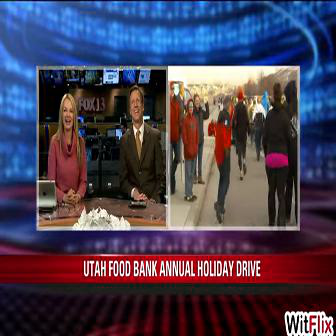

{'value': {'video_stem': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016', 'segment_id': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016_41', 'segment_index': 41, 'total_segments': 340, 'captions': 'MUCH SHIT I JUST I LOVED THEIR TRIP TO AMSTERDAM I WAS CRYING LIKE WHILE', 'segment_total_time': 4.1076249999999845, 'segment_start_time': 173.65625, 'segment_end_time': 177.76387499999998, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


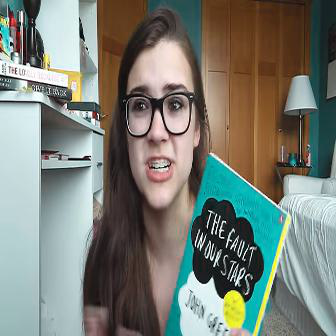

{'value': {'video_stem': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016', 'segment_id': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016_91', 'segment_index': 91, 'total_segments': 340, 'captions': "ON THERE'S A ROMANCE THAT FORMS BETWEEN MAGGIE AND THE BUILDING SUPER GRITTY KIND OF", 'segment_total_time': 5.783375000000035, 'segment_start_time': 390.102875, 'segment_end_time': 395.88625, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


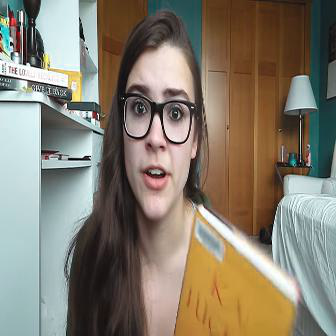

{'value': {'video_stem': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016', 'segment_id': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016_141', 'segment_index': 141, 'total_segments': 340, 'captions': "GIRL LILY WHO FALLS IN LOVE WITH A NEUROSURGEON NAMED RYLE WHO'S LIKE A DOCTOR", 'segment_total_time': 5.492937499999925, 'segment_start_time': 611.1480625, 'segment_end_time': 616.641, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


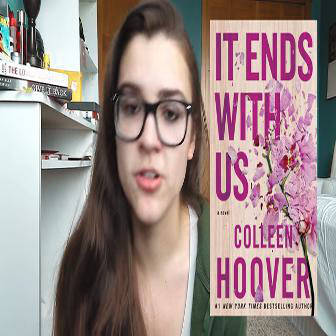

{'value': {'video_stem': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016', 'segment_id': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016_191', 'segment_index': 191, 'total_segments': 340, 'captions': 'SCENES STUFF AND IT WAS JUST AN AWESOME AWESOME MEMOIR AND I LOVED IT A', 'segment_total_time': 5.361812499999999, 'segment_start_time': 92.26075, 'segment_end_time': 97.6225625, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


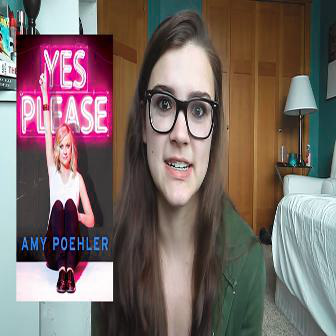

{'value': {'video_stem': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016', 'segment_id': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016_241', 'segment_index': 241, 'total_segments': 340, 'captions': 'TIME BECAUSE I READ THIS BOOK LAST APRIL AND IT ENDED ON THE BIGGEST CLIFFHANGER', 'segment_total_time': 3.533937499999979, 'segment_start_time': 301.1465, 'segment_end_time': 304.6804375, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


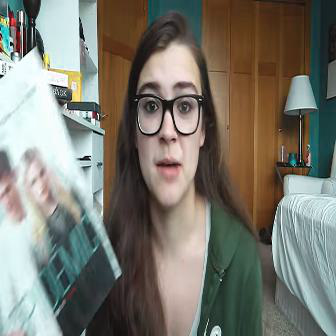

{'value': {'video_stem': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016', 'segment_id': 'JEghj7pqNNk_gabbyreads_1437_May Wrap Up ｜｜ 2016_291', 'segment_index': 291, 'total_segments': 340, 'captions': "TO MAKE COFFEE AND THEN SHE'S LIKE LOOKING AT THE WINDOW IN THE SKY SO", 'segment_total_time': 4.1456249999999955, 'segment_start_time': 525.8405, 'segment_end_time': 529.986125, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


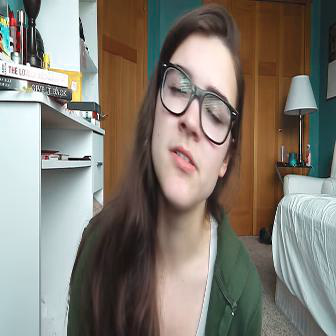

{'value': {'video_stem': 'JnrZgGUYyqM_St. Bernard Acres_2397_Off Grid Cabin Bathroom Wall Framing', 'segment_id': 'JnrZgGUYyqM_St. Bernard Acres_2397_Off Grid Cabin Bathroom Wall Framing_1', 'segment_index': 1, 'total_segments': 291, 'captions': "BE DOING SOME WORK INSIDE THE CABIN BUT THEY'RE NOT IT'S ACTUALLY DECENT OUT HERE", 'segment_total_time': 6.876375000000001, 'segment_start_time': 10.0534375, 'segment_end_time': 16.9298125, 'num_frames_per_segment': 1, 'segment_frames_shape': [1, 336, 336, 3], 'text_caption_embeddings_shape': [768], 'frame_embeddings_shape': [1, 768]}}


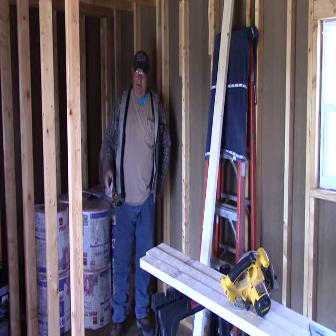

In [7]:
# read_lake.segment_metadata[2].data()['value'][total_segments]
# read_lake.text_caption_embeddings[2].data()['value']

import cv2
from PIL import Image
for i, sample in enumerate(read_lake):
  if i % 50 == 0:
    print(sample.segment_metadata.data())
    
    frame = sample.segment_frames.numpy()
    frame_rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    display(Image.fromarray(frame_rgb))
  if i > 2000:
    break

In [ ]:
read_lake.segment_metadata_json[0].data()

In [ ]:
# Read data easily!!! All together! GOD BLESS

from PIL import Image
for i in range(3):
  display(Image.fromarray(read_lake.segment_frames[i].numpy()))
  print(read_lake.segment_metadata_json[i].data()['value']['captions'])
  print(read_lake.segment_metadata_json[i].data()['value']['scene_graph_caption_txt'])

In [ ]:
ds = deeplake.empty('/mnt/storage_ssd/trying_deeplake')

In [ ]:
import numpy as np

images = ds.create_tensor('images', htype='image', sample_compression='jpg')

with ds:
    for _ in range(1000):  # 1000 random images
        random_image = np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8)  # 100x100 image with 3 channels
        ds.images.append(random_image)

In [ ]:
# ds.images[0].numpy()

from PIL import Image
Image.fromarray(ds.images[0].numpy())

In [ ]:
ds.summary()